# <center>PRÁCTICA 2: APRENDIZAJE SUPERVISADO (DengAI)<center>

**Nombre y apellidos:** Victor Christian Jaime Tamayo

**Usuario VIU:** victor.christianjaimetamayo

---
# Resumen
---

En esta práctica, se llevó a cabo la creación de múltiples modelos de aprendizaje automático con el propósito de predecir una variable específica dentro de un conjunto de datos determinado.

El procedimiento abarcó las siguientes etapas:

1. Análisis exploratorio de los datos con el fin de comprender su naturaleza, utilizando herramientas como histogramas y diagramas de dispersión.
2. Preparación de los datos para su posterior análisis y modelado.
3. Experimentación con diversos modelos de aprendizaje automático, entrenándolos mediante algoritmos de optimización de hiperparámetros.
4. Evaluación de los resultados del modelo en la plataforma Driven Data.

Se entrenaron modelos de tipo random forest, KNN,SVC y XGBoost.

Destaca que el algoritmo XGBoost obtuvo el mejor desempeño, con una puntuación de **26.0986**.

- Link de la competición:
https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/

---
# Inicialización
---

Importar las bibliotecas necesarias para esta práctica.







In [1]:
# Imports generales
import pandas as pd
import io
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import boto3
%matplotlib inline

Funciones para facilitar la carga del conjunto de datos.

In [2]:
def download_predictions_to_s3(test, pred_total_cases, bucket_name, s3_file_path):
  # Generate the file name with a timestamp
  file_name = "practica2_pred_" + time.strftime("%Y%m%d%H%M%S") + ".csv"
  
  # Create a DataFrame with the predictions
  predictions = pd.DataFrame({
    'city': test['city'], 
    'year': test['year'], 
    'weekofyear': test['weekofyear'], 
    'total_cases': pred_total_cases
  })
  # Save the DataFrame to a CSV file
  predictions.to_csv(file_name, index=False)
  
  # Initialize the S3 client
  s3_client = boto3.client('s3')
    
  # Upload the file to the specified S3 bucket
  s3_client.upload_file(file_name, bucket_name, s3_file_path + file_name)
    
  print(f"Uploaded {file_name} to s3://{bucket_name}/{s3_file_path}{file_name}")

# Example usage
# test = ... (your DataFrame)
# pred_total_cases = ... (your predictions)
# download_predictions_to_s3(test, pred_total_cases, 'your-bucket-name', 'your/s3/path/')



Cargando el conjunto de datos de entrenamiento:

In [3]:
# Getting data from AWS S3 bucket
s3 = boto3.client('s3')
obj = s3.get_object(Bucket = 'machine-learning-dengue-1337',Key = 'dengue_features_train.csv')

train_feat = pd.read_csv(obj['Body'])
print(train_feat.shape)
train_feat.head()

(1456, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


Cargando las etiquetas del conjunto de datos de entrenamiento:

In [4]:
# Getting data from AWS S3 bucket
s3 = boto3.client('s3')
obj = s3.get_object(Bucket = 'machine-learning-dengue-1337',Key = 'dengue_labels_train.csv')

train_labels = pd.read_csv(obj['Body'])
print(train_labels.shape)
train_labels.head()

(1456, 4)


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [5]:
# Unificar el conjunto de entrenamiento (características + variable objetivo)
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
print(train.shape)
train.head()

(1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6



Cargando el conjunto de datos de prueba que se utilizará para realizar las predicciones finales:

In [6]:
# Getting data from AWS S3 bucket
s3 = boto3.client('s3')
obj = s3.get_object(Bucket = 'machine-learning-dengue-1337',Key = 'dengue_features_test.csv')

test = pd.read_csv(obj['Body'])
print(test.shape)
test.head()

(416, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


---
# Reexploración
---


Obteniendo el tamaño del conjunto de datos de entrenamiento:

In [7]:
#Obtener el tamaño del dataset
print(train.shape)

(1456, 25)



El conjunto de datos de entrenamiento consta de 1456 registros, con 24 atributos y 1 variable objetivo.


Revisando el tipo de dato de cada atributo:

In [8]:
#Revisar el tipo de dato de cada variable
print(train.dtypes)

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

El conjunto de datos contiene dos columnas de tipo cadena de caracteres (string), las cuales necesitaremos preprocesar para convertirlas a tipo numérico.



Procedemos a analizar con más detalle la presencia de valores perdidos. En este caso, investigamos si existen atributos con un alto porcentaje de valores perdidos.

In [9]:
#Analizar los valores perdidos
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing values', 'Percent'])
missing_data.head(25)

,Total Missing values,Percent
ndvi_ne,194,0.133242
ndvi_nw,52,0.035714
station_avg_temp_c,43,0.029533
station_diur_temp_rng_c,43,0.029533
ndvi_se,22,0.015110
ndvi_sw,22,0.015110
station_precip_mm,22,0.015110
station_max_temp_c,20,0.013736
station_min_temp_c,14,0.009615
precipitation_amt_mm,13,0.008929



El conjunto de datos contiene valores perdidos en varios atributos; sin embargo, estos representan menos del 1% para cada atributo, por lo que no se eliminará ningún atributo debido a esta situación.

## Función para preprocesamiento de datos

Las operaciones realizadas para preprocesar el conjunto de datos son las siguientes:

1. Rellenar los valores perdidos utilizando el método de relleno hacia atrás (backward fill).
2. Crear un nuevo atributo que contenga el mes a partir de la columna "week_start_date".
3. Convertir el atributo categórico "city" a un atributo numérico utilizando la técnica de One-Hot Encoding.
4. Crear un nuevo atributo que calcule el número total de semanas desde el inicio del conjunto de datos.
5. Crear un nuevo atributo que calcule la media de los atributos NDVI.
6. Eliminar las columnas innecesarias ("week_start_date", "city_iq").


La siguiente función se encarga de llevar a cabo el preprocesamiento del conjunto de datos:

In [46]:
def processarDataset(data):
  df  = data.copy()

  #Rellenar valores perdidos usando backward fill" (llenado hacia atrás)
  #df.fillna(method='ffill', inplace=True)
  df.ffill(inplace=True)

  # Convertir la columna 'week_start_date' al tipo datetime
  df['week_start_date'] = pd.to_datetime(df['week_start_date'])

  # Extraer el mes y crear la nueva columna 'month'
  df['month'] = df['week_start_date'].dt.month

  #Convertir columna city a one hot encoding
  df = pd.get_dummies(df,columns = ['city'])

  #Convertir True/False a 1/0
  df["city_sj"]=df["city_sj"].astype(int)

  #Remover una columna del proceso de one hot encoding para el atributo city
  df.drop('city_iq', axis=1, inplace=True)

  #Remover columna week_start_date
  df.drop("week_start_date", axis = 1, inplace = True)

  # Calcular el número total de semanas desde el inicio del dataset
  df['week_from_start'] = (df['year'] - 1990) * 52 + df['weekofyear']

  # Calcular la media de NDVI
  df['mean_ndvi'] = df[['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw']].mean(axis=1)

  # Agregar columna ID al final
  df['ID'] = range(1, len(df) + 1)

  return df

## Función para visualización de datos


El objetivo de la siguiente función es visualizar el comportamiento de la variable objetivo a lo largo del tiempo.

In [37]:
#Graficar atributo
def crearGrafico(df_tmp,atributo):
  df = df_tmp.copy()
  df = df.sort_values(by='week_from_start')

  df_iquitos = df[df['city_sj'] == 0]
  df_san_juan = df[df['city_sj'] == 1]

  # Crear el gráfico
  plt.figure(figsize=(10, 6))

  # Línea para city Iquitos
  plt.plot(df_iquitos['week_from_start'], df_iquitos[atributo], label='Iquitos', color='blue')

  # Línea para city San Juan
  plt.plot(df_san_juan['week_from_start'], df_san_juan[atributo], label='San Juan', color='red')

  # Agregar etiquetas y título
  plt.xlabel('Week From Start')
  plt.ylabel(atributo)
  plt.title('Total Cases by Week From Start for City IQ')

  # Agregar leyenda
  plt.legend()

  # Mostrar el gráfico
  plt.grid(True)
  plt.show()

## Preprocesamiento del dataset

Se procede a preprocesar el conjunto de datos de entrenamiento y prueba.

In [47]:
#Preprocesamiento del dataset
train_clean = processarDataset(train)
test_clean = processarDataset(test)

A continuación se muestran los primeros 5 registros del conjunto de entrenamiento.

In [48]:
train_clean.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,month,city_sj,week_from_start,mean_ndvi,ID
0,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,6.900000,29.4,20.0,16.0,4,4,1,18,0.150606,1
1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,6.371429,31.7,22.2,8.6,5,5,1,19,0.157479,2
2,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,6.485714,32.2,22.8,41.4,4,5,1,20,0.133315,3
3,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,6.771429,33.3,23.3,4.0,3,5,1,21,0.209286,4
4,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,9.371429,35.0,23.9,5.8,6,5,1,22,0.239235,5



Se comprueba que el conjunto de datos de entrenamiento no contiene valores perdidos.

In [49]:
#Contar valores perdidos
pd.isnull(train_clean).sum()

year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
total_cases                              0
month      

### Exportar dataset procesado a S3

In [50]:
file_name = "dataset_training_dengueAI" + ".csv"
bucket_name="machine-learning-dengue-1337"
s3_file_path = "datasetDengue/"

# Save the DataFrame to a CSV file
train_clean.to_csv(file_name, index=False)

# Initialize the S3 client
s3_client = boto3.client('s3')

# Upload the file to the specified S3 bucket
s3_client.upload_file(file_name, bucket_name, s3_file_path + file_name)

print(f"Uploaded {file_name} to s3://{bucket_name}/{s3_file_path}{file_name}")

Uploaded dataset_training_dengueAI.csv to s3://machine-learning-dengue-1337/datasetDengue/dataset_training_dengueAI.csv


In [51]:
file_name = "dataset_testing_dengueAI" + ".csv"
bucket_name="machine-learning-dengue-1337"
s3_file_path = "datasetDengue/"

# Save the DataFrame to a CSV file
test_clean.to_csv(file_name, index=False)

# Initialize the S3 client
s3_client = boto3.client('s3')

# Upload the file to the specified S3 bucket
s3_client.upload_file(file_name, bucket_name, s3_file_path + file_name)

print(f"Uploaded {file_name} to s3://{bucket_name}/{s3_file_path}{file_name}")

Uploaded dataset_testing_dengueAI.csv to s3://machine-learning-dengue-1337/datasetDengue/dataset_testing_dengueAI.csv


## Exploratory Data Analysis (EDA)


### Analisis de la variable objetivo

Los modelos de machine learning en esta práctica tienen como objetivo predecir la variable objetivo "total_cases", que representa el total de casos de dengue para una ubicación y fecha específicas.

In [18]:
#Analyzar la variable objetivo
train["total_cases"].describe()

count    1456.000000
mean       24.675137
std        43.596000
min         0.000000
25%         5.000000
50%        12.000000
75%        28.000000
max       461.000000
Name: total_cases, dtype: float64


Se observa que todos los valores de la variable "total_cases" son mayores o iguales a 0. El valor mínimo y máximo de casos en una semana es de 0 y 461, respectivamente.

### Histograma de variable objetivo

Se realiza un histograma de la variable objetivo para para entender la ditribución de dicho atributo.

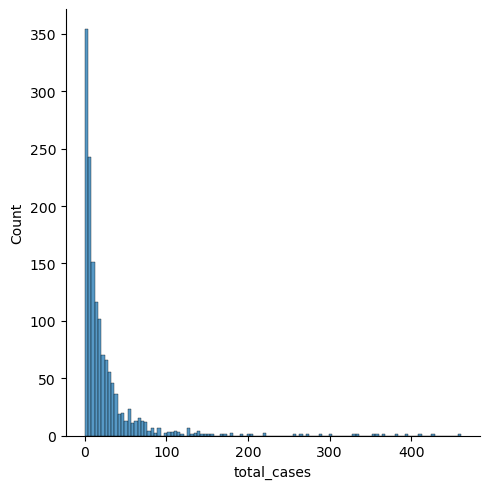

In [19]:
#histograma
sns.displot(train['total_cases']);

Del histograma, se observa que los datos siguen una distribución asimétrica positiva.

Calcular la asimetría y la curtosis:

In [20]:
#Calcular asimetria y curtosis
print("Skewness: %f" % train['total_cases'].skew())
print("Kurtosis: %f" % train['total_cases'].kurt())

Skewness: 5.273850
Kurtosis: 36.512530


* **Skewness (Asimetría)**: Un valor positivo indica que la distribución tiene una cola hacia la derecha (positiva), lo que significa que hay una concentración de valores más bajos y una dispersión de valores más altos.
En este caso, con un valor de 5.273850, la distribución está altamente sesgada hacia la derecha.

* **Kurtosis (Curtosis)**: La curtosis mide la "pesadez de la cola" de una distribución en comparación con una distribución normal estándar. Un valor mayor que 3 indica una distribución con colas más pesadas de lo normal (leptocúrtica), mientras que un valor menor que 3 indica colas más ligeras (platicúrtica).
En este caso, con un valor de 36.512530, esta distribución tiene colas muy pesadas, lo que significa que hay una mayor concentración de valores extremos en comparación con una distribución normal.

### Visualización series de tiempo


A continuación se muestra la serie de tiempo "total_cases", que representa la variable objetivo de esta práctica. El conjunto de datos contiene los datos de casos de dengue para dos ciudades diferentes: Iquitos y San Juan.

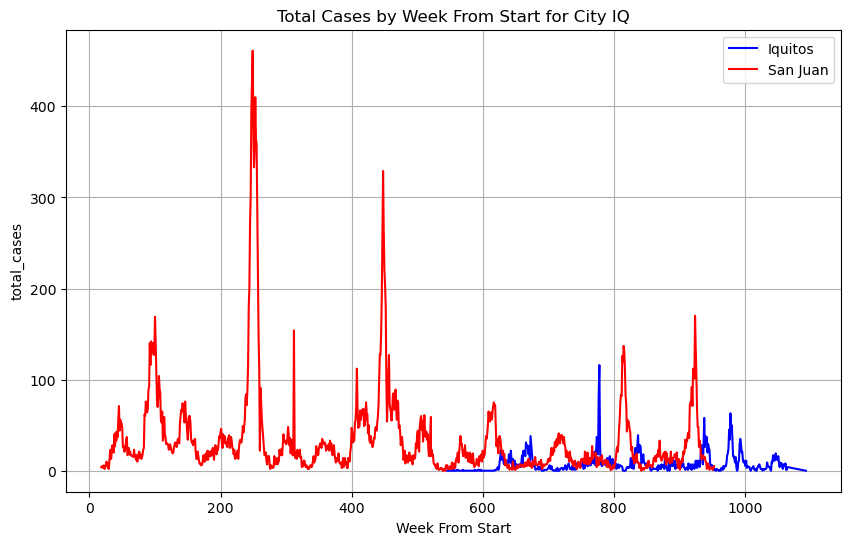

In [21]:
crearGrafico(train_clean,'total_cases')


De la gráfica anterior se observa que la serie de tiempo tiene cierto grado de estacionalidad y no presenta una tendencia clara. También se observa que el número de casos de la ciudad de Iquitos y San Juan no siguen el mismo patrón a lo largo del tiempo.

Procedemos a analizar cuántos registros existen para cada ciudad.

In [22]:
#Separar los datos por ciudad
df_iquitos = train_clean[train_clean['city_sj'] == 0]
df_san_juan = train_clean[train_clean['city_sj'] == 1]

print("Dataset San Juan")
print(df_san_juan.shape)

print("\nDataset Iquitos")
print(df_iquitos.shape)

Dataset San Juan
(936, 28)

Dataset Iquitos
(520, 28)


Se observa que se tienen 936 registros para la ciduad de San Juan y 520 para la ciudad de Iquitos.


A continuación se muestran los nombres de todas las columnas del conjunto de entrenamiento.

In [23]:
cols = list(df_san_juan.columns)
cols.sort()
print("Atributos del dataset:")
for i, col in enumerate(cols):
  print("-",col)

Atributos del dataset:
- ID
- city_sj
- mean_ndvi
- month
- ndvi_ne
- ndvi_nw
- ndvi_se
- ndvi_sw
- precipitation_amt_mm
- reanalysis_air_temp_k
- reanalysis_avg_temp_k
- reanalysis_dew_point_temp_k
- reanalysis_max_air_temp_k
- reanalysis_min_air_temp_k
- reanalysis_precip_amt_kg_per_m2
- reanalysis_relative_humidity_percent
- reanalysis_sat_precip_amt_mm
- reanalysis_specific_humidity_g_per_kg
- reanalysis_tdtr_k
- station_avg_temp_c
- station_diur_temp_rng_c
- station_max_temp_c
- station_min_temp_c
- station_precip_mm
- total_cases
- week_from_start
- weekofyear
- year


### Histogramas


Se procede a generar histogramas de todas las variables en el conjunto de datos de entrenamiento, lo que proporciona una rápida visualización de las distribuciones de las variables.

In [ ]:
# Configura el estilo de Seaborn
sns.set(style="whitegrid")

# Crea un histograma para cada variable en el DataFrame
for column in train_clean.columns:
    sns.displot(train_clean[column], kde=True, height=3)


Mediante el análisis de las distribuciones, no se observan valores atípicos significativos en los atributos del conjunto de datos.

### Análisis de casos de dengue según el mes del año

Se realiza un gráfico box plot para la ciudad de San Juan que relaciona el número de casos de dengue con el mes del año.

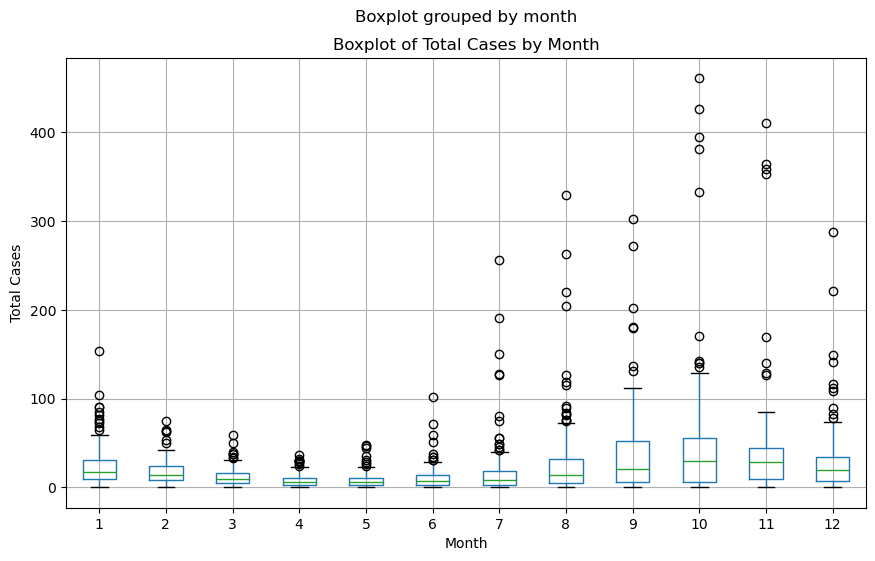

In [24]:
#generar un boxplot de la columna "total_cases" agrupado por el mes
# Suponiendo que 'month' y 'total_cases' son las columnas relevantes en tu DataFrame df
train_clean.boxplot(column='total_cases', by='month', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Total Cases')
plt.title('Boxplot of Total Cases by Month')
plt.grid(True)
plt.show()

Del gráfico anterior se observa que existe un mayor número de casos de dengue en los meses correspondientes a la segunda mitad del año.

### Matriz de correlación

Se realiza una matriz de correlación para comprender la relación entre todos los atributos del conjunto de datos.

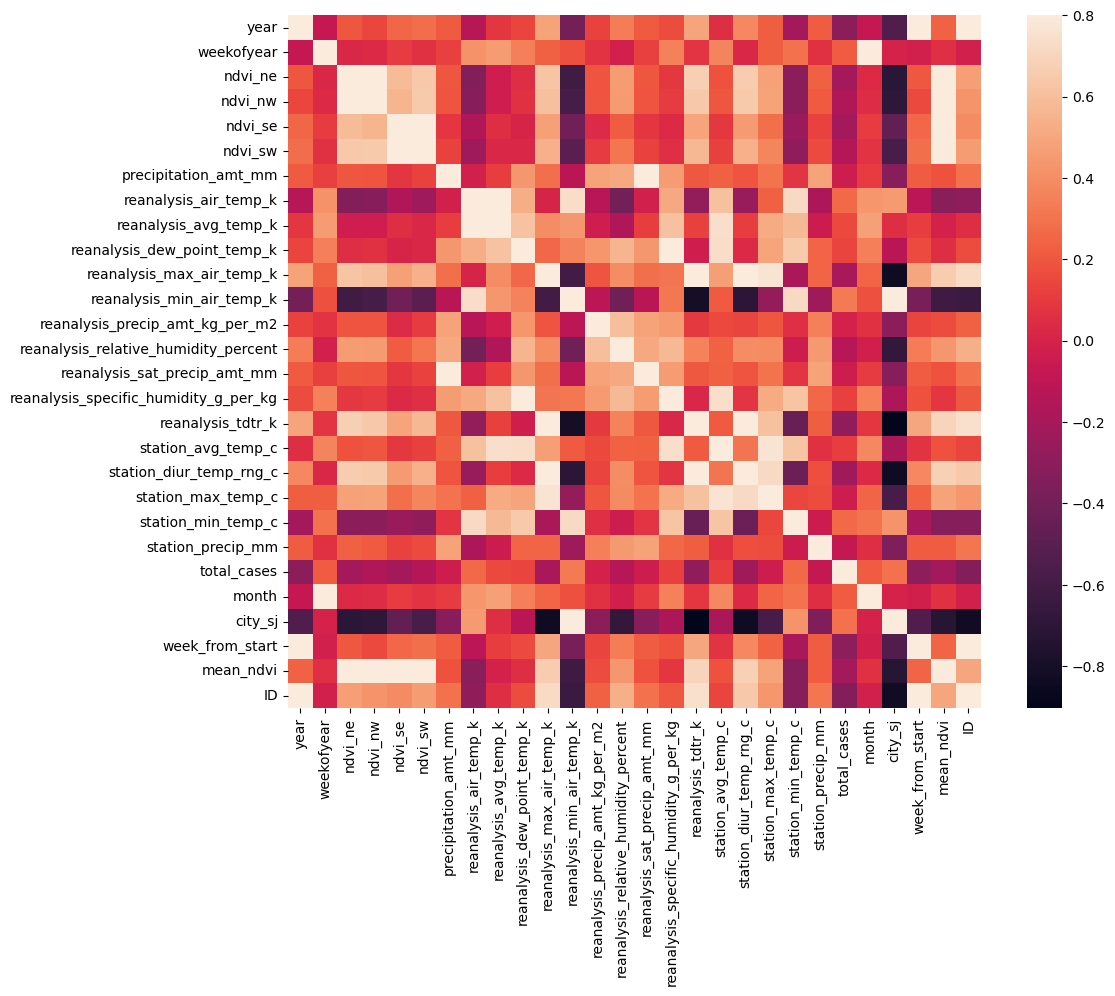

In [25]:
#Generar matriz de correlación
corrmat = train_clean.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);


Del gráfico anterior se observa lo siguiente:

- La variable objetivo muestra cierto grado de correlación con la mayoría de los atributos, sin embargo, debido al gran número de atributos, es difícil identificar cuáles tienen una correlación más fuerte.

- El nuevo atributo "mean_ndvi" presenta una fuerte correlación con los atributos "ndvi". Para evitar problemas, será necesario eliminar alguno de los atributos.


Para facilitar el análisis, se seleccionan las 10 variables con las correlaciones más altas respecto a "total_cases".

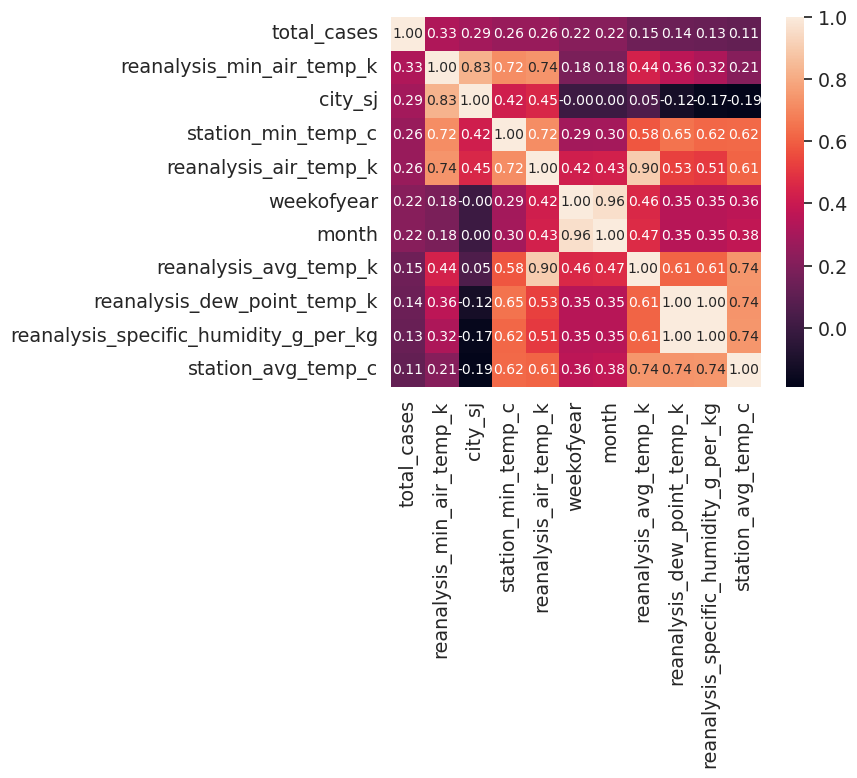

In [26]:
#Selección de las principales correlaciones:
#Se seleccionan las k variables con las correlaciones más grandes con respecto a "total_cases".

k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'total_cases')['total_cases'].index
cm = np.corrcoef(train_clean[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


De la gráfica anterior se observa que los atributos que tienen mayor correlación con la variable "total_cases" son los siguientes:



In [27]:
#Obtener las 10 variables con mayor correlacion
k = 11 #number of variables for heatmap
selected_features = corrmat.nlargest(k, 'total_cases')['total_cases'].index

cols = list(selected_features)
cols.sort()
print("Atributos con mayor correlación del dataset:")
for i, col in enumerate(cols):
  print("-",col)

Atributos con mayor correlación del dataset:
- city_sj
- month
- reanalysis_air_temp_k
- reanalysis_avg_temp_k
- reanalysis_dew_point_temp_k
- reanalysis_min_air_temp_k
- reanalysis_specific_humidity_g_per_kg
- station_avg_temp_c
- station_min_temp_c
- total_cases
- weekofyear


### Diagram de dispersión

A continuación se muestra un diagrama de dispersión para las 5 variables que tienen mayor correlación con "total_cases".

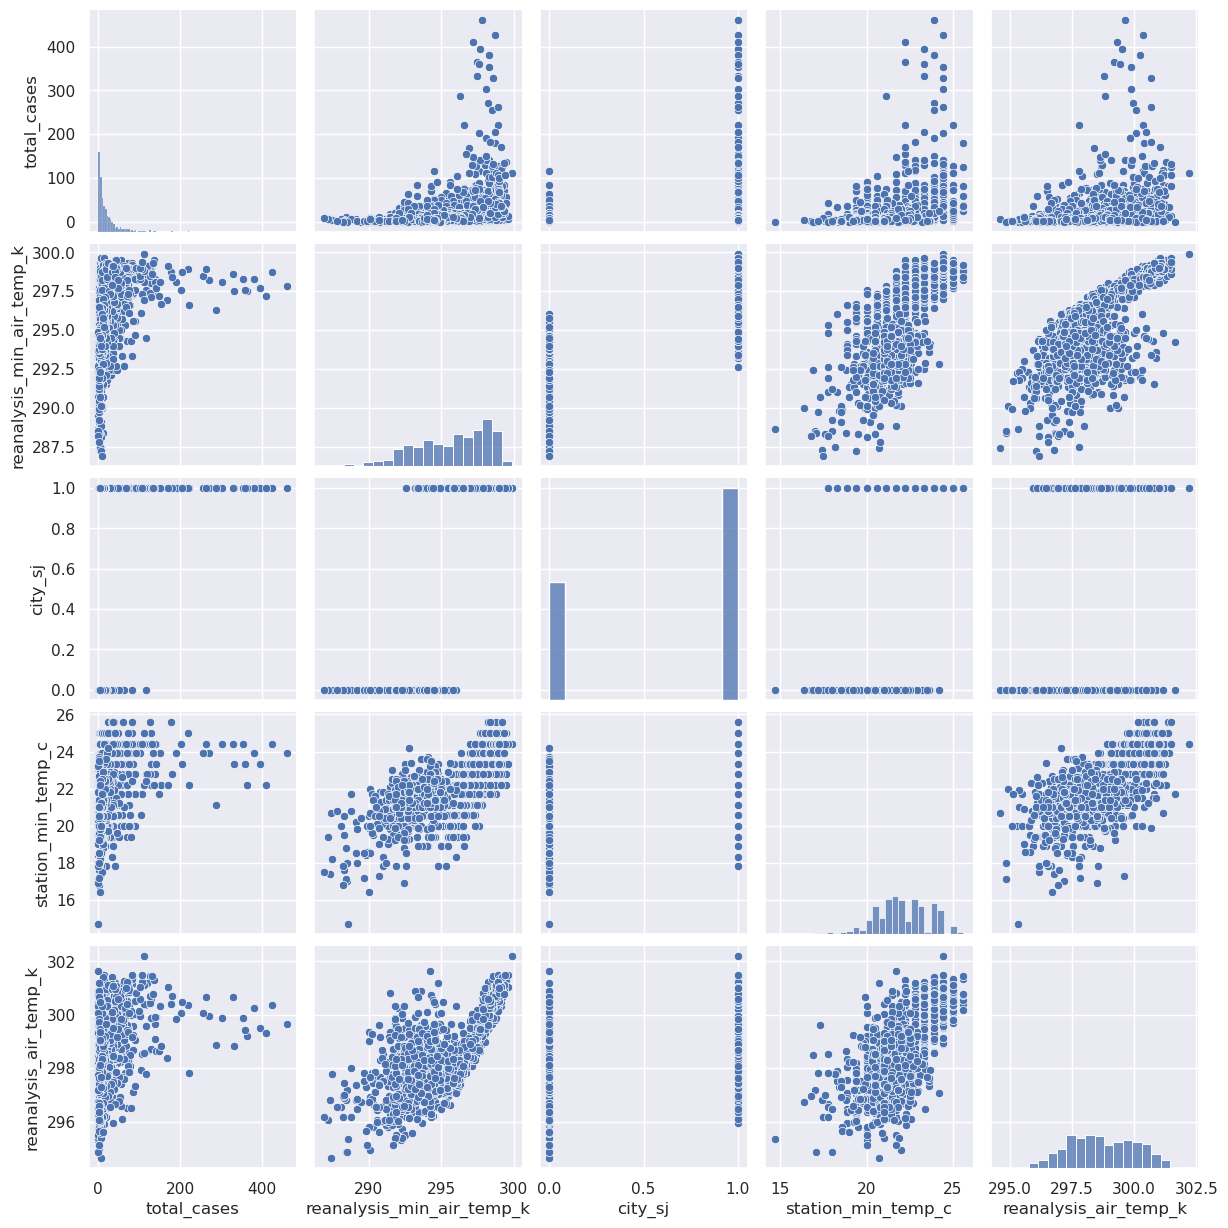

In [29]:
#Mostrar diagrama de dispersión para las 5 variables que tienen mayor correlacion con total_Cases
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'total_cases')['total_cases'].index
#scatterplot de las variables que tienen mayor correlacion
sns.set()
sns.pairplot(train_clean[cols])
plt.show();

Del gráfico anterior se observa que la variable objetivo "total_cases" tiene una ligera correlación lineal con las variables "reanalysis_min_air_temp_k", "station_min_temp_C" y "reanalysis_air_temp_k".

También se observa que "total_cases" tiende a obtener valores mayores en la ciudad de San Juan en comparación con la ciudad de Iquitos.

## Selección de atributos para el modelo de machine learning

Se llevó a cabo la selección de atributos del conjunto de datos considerando el nivel de correlación de cada atributo con la variable objetivo.

Posteriormente, se realizaron una serie de experimentos utilizando diferentes conjuntos de atributos con el objetivo de encontrar el mejor modelo. Estos experimentos se llevaron a cabo utilizando un algoritmo de Random Forest.

A continuación, se presentan los resultados de los mejores experimentos con diferentes conjuntos de atributos:

| Nombre    | MAE  | MSE       |  RMSE  |
|-----------|------|-----------|--------|
| Modelo 1  | 5.63 | 115.43    | 10.743 |
| Modelo 2  | 9.96 | 383.85    | 19.59  |
| Modelo 3  | 5.13 | 91.29     | 9.55   |
| Modelo 4  | 5.27 | 86.38     | 9.29   |

La tabla muestra que tanto el modelo 3 como el 4 obtuvieron resultados destacados, sin embargo, el modelo 4 presenta un MSE menor. Por lo tanto, en los modelos subsiguientes se utilizarán los atributos presentes en el modelo 4.

## Mejores atributos para el modelo

Después de varios experimentos, se determinó que el mejor modelo contiene los siguientes atributos:

In [30]:
selected_features=['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'month',
       'city_sj', 'week_from_start']


## Normalización de datos


Se procede a normalizar los datos para evitar que una variable tenga una influencia mayor en el modelo debido únicamente a su rango de valores.

En este caso, se utiliza un MinMaxScaler, con el cual los atributos tendrán un valor entre 0 y 1.

In [31]:
# EJEMPLO: Normalización con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_clean[selected_features])
X_test = scaler.transform(test_clean[selected_features])
y_train = train_clean['total_cases']
X_test

array([[0.9       , 0.32692308, 0.42351519, ..., 0.27272727, 1.        ,
        0.87069767],
       [0.9       , 0.34615385, 0.42449922, ..., 0.36363636, 1.        ,
        0.87162791],
       [0.9       , 0.36538462, 0.44253975, ..., 0.36363636, 1.        ,
        0.87255814],
       ...,
       [1.15      , 0.44230769, 0.70519746, ..., 0.45454545, 0.        ,
        1.11813953],
       [1.15      , 0.46153846, 0.78359177, ..., 0.45454545, 0.        ,
        1.11906977],
       [1.15      , 0.48076923, 0.81534104, ..., 0.45454545, 0.        ,
        1.12      ]])

---
# Predicción
---

### XGBOOST


Se procede a entrenar un algoritmo de XGBoost (Extreme Gradient Boosting), el cual es una implementación mejorada de algoritmos de árboles de decisión utilizando gradient boosting.

Este código realiza una búsqueda aleatoria en el espacio de hiperparámetros para determinar los mejores valores.

In [32]:
# Define el espacio de búsqueda de hiperparámetros
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'n_estimators': [50, 100],
    'colsample_bytree': [0.5, 0.6],
    'alpha': [1, 5]
}

# Instanciar el modelo de regresión de XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Instanciar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg_reg,
                                   param_distributions=param_grid,
                                   n_iter=30,
                                   scoring='neg_mean_squared_error',
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Realizar la búsqueda aleatoria en el espacio de hiperparámetros
random_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_xg_reg = random_search.best_estimator_

# Hacer predicciones en el conjunto de prueba
y_pred = best_xg_reg.predict(X_train)

# Redondear el resultado y convertirlo a entero
y = np.rint(y_pred)  # round
y = y.astype(int)  # cast to int
res = np.hstack(y)

# Cambiar valores negativos a cero
res[y_pred < 0] = 0

# Imprimir métricas de evaluación
print('XGBoost (Mejor Modelo):')
print("Mean Absolute Error:", metrics.mean_absolute_error(y_train, res))
print("Mean Squared Error:", metrics.mean_squared_error(y_train, res))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_train, res)))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
XGBoost (Mejor Modelo):
Mean Absolute Error: 8.671703296703297
Mean Squared Error: 238.78434065934067
Root Mean Squared Error: 15.452648338046805


### Modelo optimizado [XGBoost-A]

A continuación, se entrena el mejor modelo obtenido con la optimización de hiperparámetros.

In [33]:
# Definir los parámetros del modelo
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.5,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 50,
    'alpha': 5
}

# Instanciar y entrenar el modelo XGBoost
xg_reg = xgb.XGBRegressor(**params)
xg_reg.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = xg_reg.predict(X_train)

#Redondear el resultado y convertirlo a entero
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

#Cambiar valores negativos a cero
res[y_pred < 0] = 0

print("Mean Absolute Error:", metrics.mean_absolute_error(y_train, res))
print("Mean Squared Error:", metrics.mean_squared_error(y_train, res))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_train, res)))

Mean Absolute Error: 9.072802197802197
Mean Squared Error: 251.66758241758242
Root Mean Squared Error: 15.864034241566122


Generar resultados para driven data.

In [34]:
# Predicción sobre el conjunto de test
y_pred = xg_reg.predict(X_test)

# Redondear el resultado y convertirlo a entero
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

# Cambiar valores negativos a cero
res[y_pred < 0] = 0


In [35]:
#Save predictions to S3 bucket
download_predictions_to_s3(test, res, 'machine-learning-dengue-1337', 'predictions/')

Uploaded practica2_pred_20240606050615.csv to s3://machine-learning-dengue-1337/predictions/practica2_pred_20240606050615.csv



Al enviar los resultados al portal de Driven Data, se obtuvo un puntaje de **26.0986**.



<img src="https://i.ibb.co/M2XKbjc/practica2-pred-20240425044644-xgboost.png" style="height:500px" />

---
# Conclusiones
---


Basado en la comparación de los resultados de los modelos en términos de Error Absoluto Medio (MAE) tanto en los datos de entrenamiento como en el conjunto de datos de prueba de DrivenData, se concluye que el modelo elegido es el modelo **XGBoost**.

Este modelo proporciona el MAE más bajo en el conjunto de datos de prueba de DrivenData, lo que sugiere una mejor capacidad de generalización.

| Modelo | MAE test (DrivenData) | MAE validación | Algoritmo | Hiperparámetros | Descripción
| --- | --- | --- | --- | --- | --- |
| XGBoost-A | 26.0986 | 9.3413 | XGBoost | [0.5,0.1,3,50,5] | XGBoost con optimización randomized search
| RandomForest-A | 26.4904 | 5.2733 | Random Forest | [100,10,3,2,0,123] | Random Forest con optimización randomized-grid search
| KNN-A | 26.4976 | 15.4958 | KNN | [20,'uniform','auto'] | KNN con optimización randomized search
| SVR-B | NA | 15.2108 | SVR | [Polinomial] | SVR con kernel polinomial
| SVR-C | NA | 15.7673 | SVR | [Radial] | SVR con kernel radial
| SVR-D | NA | 17.1353 | SVR | [Lineal] | SVR con kernel lineal


**Modelo final elegido**
* Nombre/Identificador: Final
* MAE test (DrivenData): 26.0986
* MAE validación: 9.3413
* Algoritmo ML: XGBoost
* Hiperparámetros:
    ['objective': 'reg:squarederror',
    'colsample_bytree': 0.5,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 50,
    'alpha': 5]
* Lista de características: XGBoost con optimización de hiperparámetros mediante randomized search.
* Resumen del dataset (transformaciones aplicadas, etc.):

  1. Rellenar los valores perdidos utilizando el método de relleno hacia atrás (backward fill).
  2. Crear un nuevo atributo que contenga el mes a partir de la columna "week_start_date".
  3. Convertir el atributo categórico "city" a un atributo numérico utilizando la técnica de One-Hot Encoding.
  4. Crear un nuevo atributo que calcule el número total de semanas desde el inicio del conjunto de datos.
  5. Crear un nuevo atributo que calcule la media de los atributos NDVI.
  6. Eliminar las columnas innecesarias ("week_start_date", "city_iq").
  7. Normalizar los datos con un MinMaxScaler.


Basado en la comparación de los resultados de los modelos en términos de Error Absoluto Medio (MAE) tanto en los datos de entrenamiento como en el conjunto de datos de prueba de DrivenData, se observa que el modelo XGBoost (Modelo Final) ha demostrado consistentemente un rendimiento superior.

En el conjunto de datos de prueba de DrivenData, el modelo XGBoost proporcionó el MAE más bajo en comparación con los otros modelos evaluados, lo que sugiere una mejor capacidad de generalización.

Esta elección se ve respaldada por el hecho de que el modelo XGBoost fue entrenado utilizando una optimización aleatoria de hiperparámetros, lo que permite una exploración más exhaustiva del espacio de búsqueda de parámetros y puede conducir a una mejor configuración del modelo en comparación con los otros modelos que utilizaron diferentes técnicas de optimización. Por lo tanto, se concluye que el modelo XGBoost es la opción preferida para este problema de predicción de casos de dengue.

Como trabajo futuro, se podría llevar a cabo una búsqueda más exhaustiva durante la optimización de hiperparámetros, explorando un espacio más amplio de posibles configuraciones. Además, sería interesante considerar el entrenamiento de modelos más complejos, como los modelos de deep learning, para evaluar su rendimiento en este problema específico de predicción de casos de dengue.

---
# Competición
---

A continuación se muestran los mejores resultados sometidos a la competición de driven data.

El usuario de Driven Data es: **ChrisXT127**

<img src="https://i.ibb.co/vVDYpn2/driven-data-xgboost.png" style="height:500px" />

Donde el mejor resultado corresponde al obtenido con el algoritmo XGBOOST.
Con un scode de **26.0986**.